In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns

In [21]:
file_path = r'C:\Users\Hiroo\Downloads\Campus\Year 4\Semester 1\ST 4052 - Statistical Learning II\Data Analysis Project I\tiktok_claims.csv'
df = pd.read_csv(file_path)

In [22]:
df.drop(columns = ['id','video_id'], inplace = True)

In [23]:
df.isnull().sum()

claim_status                298
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [24]:
df_cleaned = df.dropna(subset=['claim_status'])

In [25]:
df_cleaned.isnull().sum()

claim_status                0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [26]:
# percentage of missing values
298/len(df)*100

1.5375090289959756

#### Feature Engineering

In [27]:
# text length

df_cleaned['text_length'] = df_cleaned['video_transcription_text'].str.len()
df_cleaned = df_cleaned.drop(['video_transcription_text'], axis=1)

df_cleaned

C:\Users\HP\AppData\Local\Temp\ipykernel_17784\810763613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['text_length'] = df_cleaned['video_transcription_text'].str.len()


,claim_status,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,claim,59,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,claim,32,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,claim,31,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,claim,25,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,claim,19,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128
...,...,...,...,...,...,...,...,...,...,...
19079,opinion,49,not verified,active,6067.0,423.0,81.0,8.0,2.0,65
19080,opinion,23,not verified,active,2973.0,820.0,70.0,3.0,0.0,66
19081,opinion,50,not verified,active,734.0,102.0,7.0,2.0,1.0,53
19082,opinion,8,not verified,active,3394.0,655.0,123.0,11.0,4.0,80


### Splitting Data into training and testing

In [46]:
X = df_cleaned.drop('claim_status', axis=1)
Y = df_cleaned['claim_status']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=50)
train = X_train.join(y_train)
test = X_test.join(y_test)

### K Prototypes and Random Forest

In [43]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


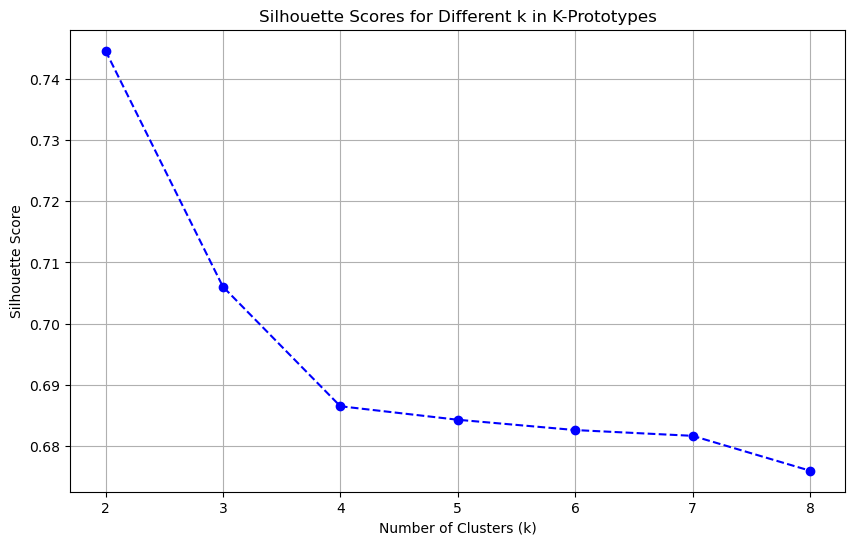

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

categorical_columns = ['verified_status', 'author_ban_status']
numeric_data = X_train.drop(columns = ['verified_status', 'author_ban_status'])

silhouette_scores = []
k_values = range(2, 9)

for k in k_values:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
    clusters = kproto.fit_predict(X_train, categorical = [X_train.columns.get_loc(col) for col in categorical_columns])    
    try:
        score = silhouette_score(numeric_data, clusters)
    except ValueError as e:
        print(f"Silhouette score computation failed for k={k}: {e}")
        score = -1
    
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Scores for Different k in K-Prototypes')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))
plt.grid(True)
plt.show()

In [118]:
from kmodes.kprototypes import KPrototypes

categorical_columns = ['verified_status', 'author_ban_status']

# Fit K-Prototypes
kproto = KPrototypes(n_clusters=2, init='Huang', random_state=42)
clusters = kproto.fit_predict(X_train, categorical = [X_train.columns.get_loc(col) for col in categorical_columns])

# Assign clusters back to the dataframe
X_train['Kproto_Cluster'] = clusters

In [119]:
import prince
import matplotlib.pyplot as plt
import seaborn as sns

# Perform FAMD
famd = prince.FAMD(n_components=2, random_state=42)
famd = famd.fit(X_train.drop('Kproto_Cluster', axis=1))

# Transform data into the FAMD space
famd_df = famd.transform(X_train.drop('Kproto_Cluster', axis=1))

# Add cluster labels and response categories
famd_df['Kproto_Cluster'] = X_train['Kproto_Cluster'].values
famd_df['Response'] = y_train.values

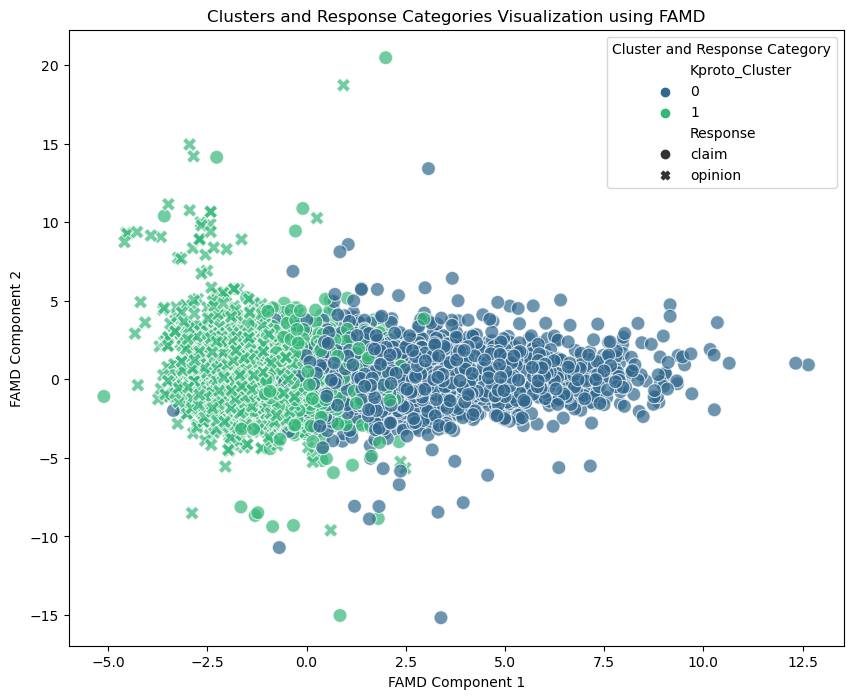

In [120]:
# Plot the results
plt.figure(figsize=(10, 8))

# Use different markers for each response category
markers = {'opinion': 'X', 'claim': 'o'}  # Modify based on your response categories

sns.scatterplot(x=famd_df[0], 
                y=famd_df[1], 
                hue=famd_df['Kproto_Cluster'],
                style=famd_df['Response'],
                markers=markers,
                alpha=0.7,
                palette='viridis', 
                s=100)

plt.title('Clusters and Response Categories Visualization using FAMD')
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')
plt.legend(title='Cluster and Response Category')
plt.show()

In [121]:
from sklearn.metrics import silhouette_score

numeric_data = X_train.drop(columns = ['Kproto_Cluster', 'verified_status', 'author_ban_status'])
cluster_labels = X_train['Kproto_Cluster'].values
silhouette_avg = silhouette_score(numeric_data, cluster_labels)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.7438165753638207


In [122]:
# Create a contingency table
cluster_response_table = pd.crosstab(famd_df['Kproto_Cluster'], famd_df['Response'], rownames=['Cluster'], colnames=['Response'])
print(cluster_response_table)

Response  claim  opinion
Cluster                 
0          4283        0
1          2438     6637


In [123]:
X_test['Kproto_Cluster'] = kproto.predict(X_test, categorical = [X_train.columns.get_loc(col) for col in categorical_columns])

In [124]:
cluster1_Xtrain = X_train[X_train['Kproto_Cluster'] == 1]
cluster1_Xtrain = cluster1_Xtrain.drop(columns = ['Kproto_Cluster'])

cluster1_ytrain = y_train[X_train['Kproto_Cluster'] == 1]

In [125]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

categorical_cols = ['verified_status', 'author_ban_status']
numerical_cols = ['video_duration_sec', 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count', 'text_length']

rf_model = RandomForestClassifier(n_estimators=100, random_state=100)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
    
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)])
    
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',  rf_model)])

param_grid = {
    'classifier__n_estimators': [30, 50, 80],  # Number of trees in the forest
    'classifier__max_depth': [8, 10],  # Maximum depth of each tree
    'classifier__min_samples_split': [4, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [4, 10],    # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(cluster1_Xtrain, cluster1_ytrain)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated accuracy: {best_score:.4f}")

# Fit the best model on the entire training data
best_rf_pipeline = grid_search.best_estimator_

Best parameters: {'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 50}
Best cross-validated accuracy: 0.9925


In [126]:
def predict_response(row):
    if row['Kproto_Cluster'] == 0:
        return 'claim' 
    elif row['Kproto_Cluster'] == 1:
        # Convert the row to a DataFrame with a single row to match the expected input format
        X_test_cluster1 = pd.DataFrame([row.drop('Kproto_Cluster')])
        return best_rf_pipeline.predict(X_test_cluster1)[0]

# Apply the function to the DataFrame
X_train['Predicted_Response'] = X_train.apply(predict_response, axis=1)
rf_train_ypred = X_train['Predicted_Response']
X_train = X_train.drop(columns=['Predicted_Response'])

In [127]:
X_test['Predicted_Response'] = X_test.apply(predict_response, axis=1)
rf_test_ypred = X_test['Predicted_Response']
X_test= X_test.drop(columns = ['Predicted_Response'])

In [128]:
from sklearn.metrics import classification_report
train_accuracy = accuracy_score(y_train, rf_train_ypred)
test_accuracy = accuracy_score(y_test, rf_test_ypred)

report = classification_report(y_test, rf_test_ypred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print('Classification Report:')
print(report)

Train Accuracy: 0.9955083096271897
Test Accuracy: 0.9951100244498777
Classification Report:
              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



In [129]:
contingency_table = pd.crosstab(y_test, rf_test_ypred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2862       25
opinion        3     2836


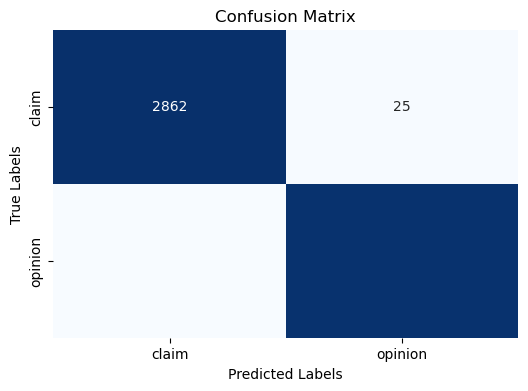

In [130]:
plt.figure(figsize=(6, 4))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Text(0.5, 0, 'Permutation Importance')

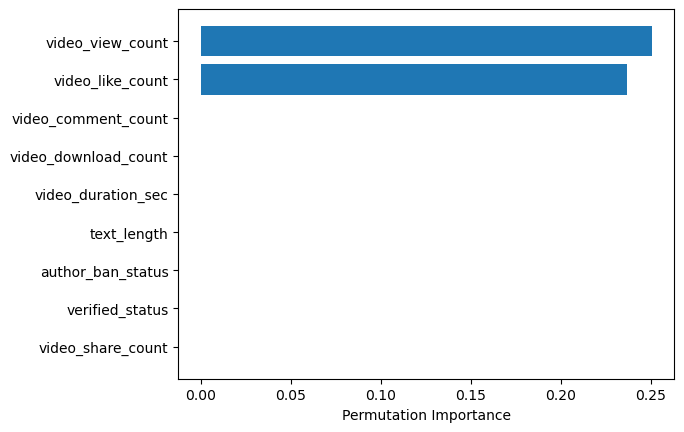

In [131]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
%matplotlib inline

perm_importance = permutation_importance(best_rf_pipeline, X_test.drop(columns = ['Kproto_Cluster']), y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#### K Proto + Random Forest with 3 variables

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cluster1_Xtrain_num = cluster1_Xtrain[['video_view_count', 'video_like_count']]

numerical_cols = ['video_view_count', 'video_like_count']
    
rf_model = RandomForestClassifier(n_estimators=100, random_state=100)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()
    
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols)])
    
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',  rf_model)])
    
pipeline.fit(cluster1_Xtrain_num, cluster1_ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['video_view_count',
                                                   'video_like_count'])])),
                ('classifier', RandomForestClassifier(random_state=100))])

In [133]:
def predict_response(row):
    if row['Kproto_Cluster'] == 0:
        return 'claim' 
    elif row['Kproto_Cluster'] == 1:
        # Convert the row to a DataFrame with a single row to match the expected input format
        X_test_cluster1 = pd.DataFrame([row.drop('Kproto_Cluster')])
        return pipeline.predict(X_test_cluster1)[0]

X_train_rf = X_train[['video_view_count', 'video_like_count', 'Kproto_Cluster']]
X_test_rf = X_test[['video_view_count', 'video_like_count', 'Kproto_Cluster']]

# Apply the function to the DataFrame
X_train_rf['Predicted_Response'] = X_train_rf.apply(predict_response, axis=1)
rf_train_ypred = X_train_rf['Predicted_Response']
X_train_rf = X_train_rf.drop(columns=['Predicted_Response'])

C:\Users\HP\AppData\Local\Temp\ipykernel_17808\1789022466.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_rf['Predicted_Response'] = X_train_rf.apply(predict_response, axis=1)


In [134]:
X_test_rf['Predicted_Response'] = X_test_rf.apply(predict_response, axis=1)
rf_test_ypred = X_test_rf['Predicted_Response']
X_test_rf= X_test_rf.drop(columns = ['Predicted_Response'])

C:\Users\HP\AppData\Local\Temp\ipykernel_17808\3002828259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_rf['Predicted_Response'] = X_test_rf.apply(predict_response, axis=1)


In [135]:
train_accuracy = accuracy_score(y_train, rf_train_ypred)
test_accuracy = accuracy_score(y_test, rf_test_ypred)

report = classification_report(y_test, rf_test_ypred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print('Classification Report:')
print(report)

Train Accuracy: 0.9999251384937865
Test Accuracy: 0.9959832343695424
Classification Report:
              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



In [136]:
contingency_table = pd.crosstab(y_test, rf_test_ypred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2864       23
opinion        0     2839


### Random Forest

In [156]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

categorical_cols = ['verified_status', 'author_ban_status']
numerical_cols = ['video_duration_sec', 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count', 'text_length']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier())])

param_grid = {
    'classifier__n_estimators': [50, 100],  # Number of trees in the forest
    'classifier__max_depth': [10, 20],  # Maximum depth of each tree
    'classifier__min_samples_split': [5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [5, 10],    # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ["sqrt", "log2"]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated accuracy: {best_score:.4f}")

# Fit the best model on the entire training data
best_rf_pipeline = grid_search.best_estimator_

# Predictions and accuracy
rf0_train_pred = best_rf_pipeline.predict(X_train)
rf0_test_pred = best_rf_pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, rf0_train_pred)
test_accuracy = accuracy_score(y_test, rf0_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

from sklearn.metrics import classification_report
report = classification_report(y_test, rf0_test_pred)

Best parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best cross-validated accuracy: 0.9951
Train Accuracy: 0.9951
Test Accuracy: 0.9949


In [157]:
print(report)

              precision    recall  f1-score   support

       claim       1.00      0.99      0.99      2887
     opinion       0.99      1.00      0.99      2839

    accuracy                           0.99      5726
   macro avg       0.99      0.99      0.99      5726
weighted avg       0.99      0.99      0.99      5726



In [158]:
contingency_table = pd.crosstab(y_test, rf0_test_pred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2859       28
opinion        1     2838


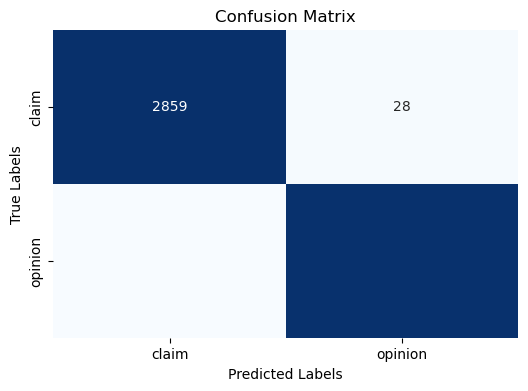

In [159]:
plt.figure(figsize=(6, 4))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Text(0.5, 0, 'Permutation Importance')

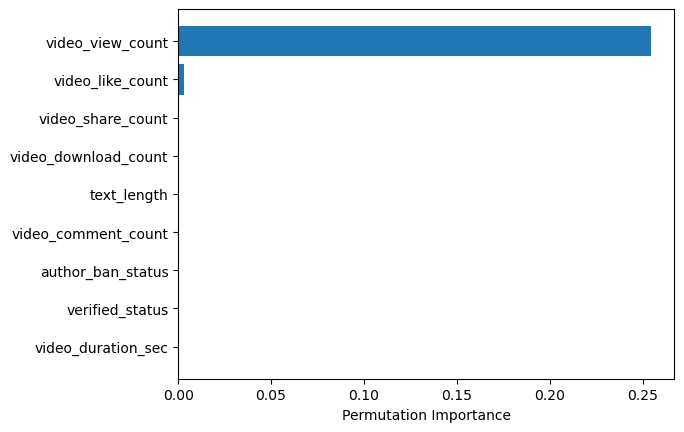

In [160]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
%matplotlib inline

perm_importance = permutation_importance(best_rf_pipeline, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Random Forest considering only the important variables

In [170]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

numerical_cols1 = ['video_view_count']


numerical_transformer = StandardScaler()

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols1)
    ])


rf_pipeline1 = Pipeline(steps=[('preprocessor', preprocessor1),
                              ('classifier', RandomForestClassifier())])

param_grid = {
    'classifier__n_estimators': [50, 100],  # Number of trees in the forest
    'classifier__max_depth': [10, 20],  # Maximum depth of each tree
    'classifier__min_samples_split': [5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [5, 10],    # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ["sqrt", "log2"]
}

X_train_2var = X_train[['video_view_count']]
X_test_2var = X_test[['video_view_count']]

grid_search = GridSearchCV(rf_pipeline1, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_2var, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated accuracy: {best_score:.4f}")

# Fit the best model on the entire training data
best_rf_pipeline1 = grid_search.best_estimator_

# Predictions and accuracy
rf1_train_pred = best_rf_pipeline1.predict(X_train_2var)
rf1_test_pred = best_rf_pipeline1.predict(X_test_2var)

train_accuracy = accuracy_score(y_train, rf1_train_pred)
test_accuracy = accuracy_score(y_test, rf1_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

from sklearn.metrics import classification_report
report = classification_report(y_test, rf1_test_pred)

Best parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best cross-validated accuracy: 0.9949
Train Accuracy: 0.9949
Test Accuracy: 0.9951


In [171]:
print(report)

              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



In [172]:
contingency_table = pd.crosstab(y_test, rf1_test_pred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2859       28
opinion        0     2839


### KNN

In [173]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

categorical_cols = ['verified_status', 'author_ban_status']
numerical_cols = ['video_duration_sec', 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count', 'text_length']

# Define transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a KNN pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])

In [165]:
error_rates = []

# Iterate over a range of k values
for k in range(1, 21):
    knn_pipeline.set_params(classifier__n_neighbors=k)
    knn_pipeline.fit(X_train, y_train)
    y_pred = knn_pipeline.predict(X_test)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

# Plotting the error rate vs k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), error_rates, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.xticks(np.arange(1, 21, 1))
plt.show()

KeyboardInterrupt: 

In [174]:
#optimal_k = np.argmin(error_rates) + 1  # np.argmin returns the index of the min value, add 1 to match the actual k value
optimal_k = 4
print(f"Optimal k: {optimal_k}")

# Fit the model with the optimal k
knn_pipeline.set_params(classifier__n_neighbors=optimal_k)
knn_pipeline.fit(X_train, y_train)

# Predictions and accuracy
knn_train_pred = knn_pipeline.predict(X_train)
knn_test_pred = knn_pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, knn_train_pred)
test_accuracy = accuracy_score(y_test, knn_test_pred)

from sklearn.metrics import classification_report
report = classification_report(y_test, knn_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print(report)

Optimal k: 4
Train Accuracy: 0.9792
Test Accuracy: 0.9731
              precision    recall  f1-score   support

       claim       0.99      0.96      0.97      2887
     opinion       0.96      0.99      0.97      2839

    accuracy                           0.97      5726
   macro avg       0.97      0.97      0.97      5726
weighted avg       0.97      0.97      0.97      5726



In [175]:
contingency_table = pd.crosstab(y_test, knn_test_pred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2758      129
opinion       25     2814


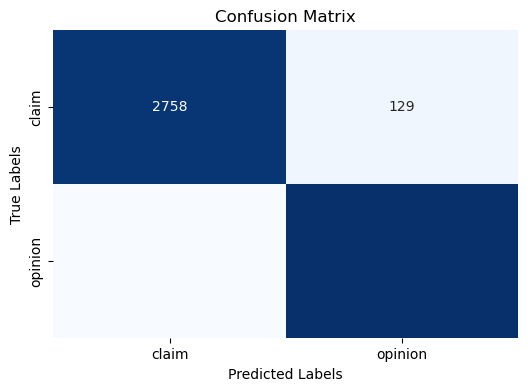

In [176]:
plt.figure(figsize=(6, 4))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Fisher's Discriminant Analysis

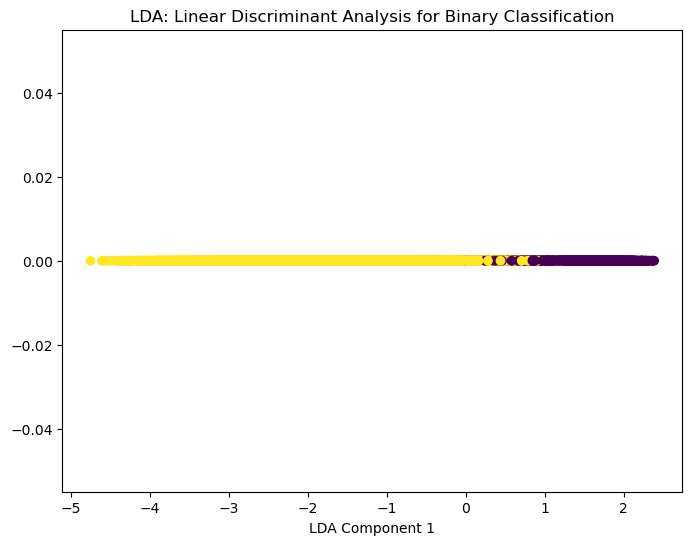

Training Accuracy: 0.89
Testing Accuracy: 0.89


In [177]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline with LDA
lda_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lda', LDA(n_components=1))  # For binary classification, use n_components=1
])

# Fit LDA
X_lda = lda_pipeline.fit_transform(X_train, y_train)

# Visualizing the results
plt.figure(figsize=(8, 6))
plt.scatter(X_lda, np.zeros_like(X_lda), c=y_train.map({'opinion': 0, 'claim': 1}), cmap = 'viridis')
plt.xlabel('LDA Component 1')
plt.title('LDA: Linear Discriminant Analysis for Binary Classification')
plt.show()

# Optionally, you can evaluate the model on the training set or a separate test set
train_accuracy = lda_pipeline.score(X_train, y_train)
test_accuracy = lda_pipeline.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

### Fisher's Discriminant Analysis - only for numerical columns

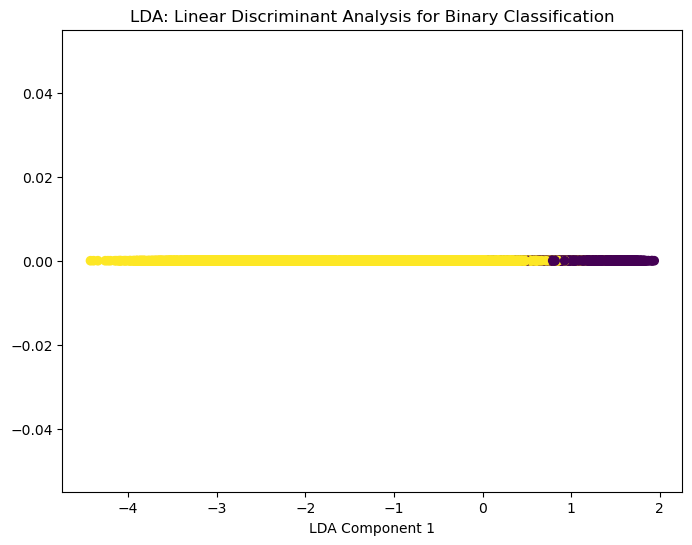

Training Accuracy: 0.8806
Testing Accuracy: 0.8783
Test Report:
               precision    recall  f1-score   support

       claim       1.00      0.76      0.86      2887
     opinion       0.80      1.00      0.89      2839

    accuracy                           0.88      5726
   macro avg       0.90      0.88      0.88      5726
weighted avg       0.90      0.88      0.88      5726



In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

X_train_num = X_train.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

lda = LDA(n_components=1)

# Fit LDA
X_lda = lda.fit_transform(X_train_num, y_train)

# Visualizing the results
plt.figure(figsize=(8, 6))
plt.scatter(X_lda, np.zeros_like(X_lda), c=y_train.map({'opinion': 0, 'claim': 1}), cmap = 'viridis')
plt.xlabel('LDA Component 1')
plt.title('LDA: Linear Discriminant Analysis for Binary Classification')
plt.show()

# Optionally, you can evaluate the model on the training set or a separate test set
train_accuracy = lda.score(X_train_num, y_train)
test_accuracy = lda.score(X_test_num, y_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

from sklearn.metrics import classification_report
lda_pred = lda.predict(X_test_num)
test_report = classification_report(y_test, lda_pred)
print("Test Report:\n", test_report)

In [179]:
contingency_table = pd.crosstab(y_test, lda_pred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2190      697
opinion        0     2839


### AdaBoost

In [29]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred0 = pipeline.predict(X_train)
y_pred1 = pipeline.predict(X_test)

# Evaluate
train_accuracy = accuracy_score(y_train, y_pred0)
test_accuracy = accuracy_score(y_test, y_pred1)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Accuracy: 0.9957
Test Accuracy: 0.9955


In [30]:
contingency_table = pd.crosstab(y_test, y_pred1, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2862       25
opinion        1     2838


In [31]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred1)
print(report)

              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



Text(0.5, 0, 'Permutation Importance')

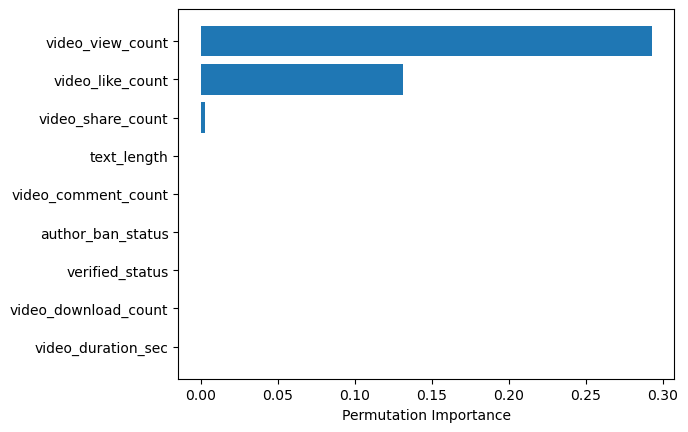

In [32]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
%matplotlib inline

perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### AdaBoost with selected variables

In [33]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_train_ada = X_train[['video_view_count', 'video_like_count']]
X_test_ada = X_test[['video_view_count', 'video_like_count']]

numerical_cols = X_train_ada.select_dtypes(include=['number']).columns
#categorical_cols = X_train_ada.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)])

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50))
])

# Train the model
pipeline.fit(X_train_ada, y_train)

# Make predictions
y_pred0 = pipeline.predict(X_train_ada)
y_pred1 = pipeline.predict(X_test_ada)

# Evaluate
train_accuracy = accuracy_score(y_train, y_pred0)
test_accuracy = accuracy_score(y_test, y_pred1)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Accuracy: 0.9957
Test Accuracy: 0.9956


In [34]:
contingency_table = pd.crosstab(y_test, y_pred1, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2862       25
opinion        0     2839


### Bagging

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Define the BaggingClassifier with DecisionTreeClassifier as the base estimator
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Number of base estimators
    random_state=42
)

# Create the full pipeline that first preprocesses the data and then applies the BaggingClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', bagging_clf)
])


# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred0 = pipeline.predict(X_train)
y_pred1 = pipeline.predict(X_test)

# Evaluate
train_accuracy = accuracy_score(y_train, y_pred0)
test_accuracy = accuracy_score(y_test, y_pred1)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Accuracy: 0.9999
Test Accuracy: 0.9960


In [37]:
contingency_table = pd.crosstab(y_test, y_pred1, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2864       23
opinion        0     2839


In [38]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred1)
print(report)

              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



Text(0.5, 0, 'Permutation Importance')

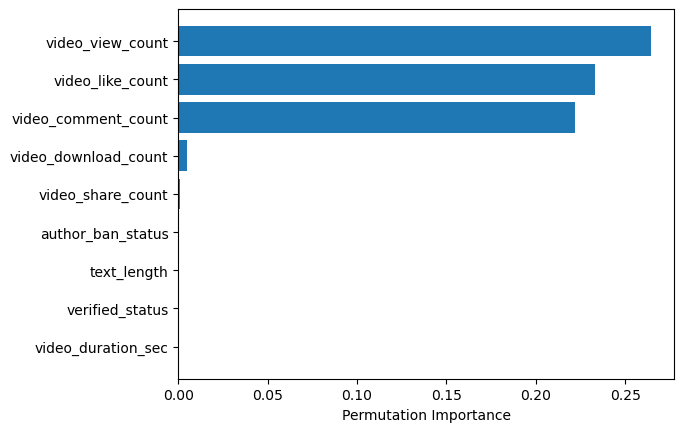

In [39]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
%matplotlib inline

perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Bagging with selected variables

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train_bag = X_train[['video_view_count', 'video_like_count', 'video_comment_count']]
X_test_bag = X_test[['video_view_count', 'video_like_count', 'video_comment_count']]

numerical_cols = X_train_bag.select_dtypes(include=['number']).columns
categorical_cols = X_train_bag.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ])

# Define the BaggingClassifier with DecisionTreeClassifier as the base estimator
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Number of base estimators
    random_state=42
)

# Create the full pipeline that first preprocesses the data and then applies the BaggingClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', bagging_clf)
])


# Fit the pipeline to the training data
pipeline.fit(X_train_bag, y_train)

# Make predictions on the test data
y_pred0 = pipeline.predict(X_train_bag)
y_pred1 = pipeline.predict(X_test_bag)

# Evaluate
train_accuracy = accuracy_score(y_train, y_pred0)
test_accuracy = accuracy_score(y_test, y_pred1)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Accuracy: 0.9999
Test Accuracy: 0.9958


In [41]:
contingency_table = pd.crosstab(y_test, y_pred1, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2864       23
opinion        1     2838


In [43]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred1)
print(report)

              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



### K Proto + AdaBoost

In [47]:
from kmodes.kprototypes import KPrototypes

categorical_columns = ['verified_status', 'author_ban_status']

# Fit K-Prototypes
kproto = KPrototypes(n_clusters=2, init='Huang', random_state=42)
clusters = kproto.fit_predict(X_train, categorical = [X_train.columns.get_loc(col) for col in categorical_columns])

# Assign clusters back to the dataframe
X_train['Kproto_Cluster'] = clusters

In [48]:
X_test['Kproto_Cluster'] = kproto.predict(X_test, categorical = [X_train.columns.get_loc(col) for col in categorical_columns])

In [49]:
cluster1_Xtrain = X_train[X_train['Kproto_Cluster'] == 1]
cluster1_Xtrain = cluster1_Xtrain.drop(columns = ['Kproto_Cluster'])

cluster1_ytrain = y_train[X_train['Kproto_Cluster'] == 1]

In [50]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

numerical_cols = cluster1_Xtrain.select_dtypes(include=['number']).columns
categorical_cols = cluster1_Xtrain.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50))
])

# Train the model
pipeline.fit(cluster1_Xtrain, cluster1_ytrain)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['video_duration_sec', 'video_view_count', 'video_like_count',
       'video_share_count', 'video_download_count', 'video_comment_count',
       'text_length'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['verified_status', 'author_ban_status'], dtype='object'))])),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)))])

In [51]:
def predict_response(row):
    if row['Kproto_Cluster'] == 0:
        return 'claim' 
    elif row['Kproto_Cluster'] == 1:
        # Convert the row to a DataFrame with a single row to match the expected input format
        X_test_cluster1 = pd.DataFrame([row.drop('Kproto_Cluster')])
        return pipeline.predict(X_test_cluster1)[0]
    

# Apply the function to the DataFrame
X_train['Predicted_Response'] = X_train.apply(predict_response, axis=1)
ada_train_ypred = X_train['Predicted_Response']
X_train = X_train.drop(columns=['Predicted_Response'])

In [52]:
X_test['Predicted_Response'] = X_test.apply(predict_response, axis=1)
ada_test_ypred = X_test['Predicted_Response']
X_test= X_test.drop(columns = ['Predicted_Response'])

In [53]:
from sklearn.metrics import classification_report
train_accuracy = accuracy_score(y_train, ada_train_ypred)
test_accuracy = accuracy_score(y_test, ada_test_ypred)

report = classification_report(y_test, ada_test_ypred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print('Classification Report:')
print(report)

Train Accuracy: 0.9957328941458302
Test Accuracy: 0.9954593084177437
Classification Report:
              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



In [54]:
contingency_table = pd.crosstab(y_test, ada_test_ypred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2862       25
opinion        1     2838


### K proto + Bagging

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

numerical_cols = cluster1_Xtrain.select_dtypes(include=['number']).columns
categorical_cols = cluster1_Xtrain.select_dtypes(include=['object', 'category']).columns

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Define the BaggingClassifier with DecisionTreeClassifier as the base estimator
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Number of base estimators
    random_state=42
)

# Create the full pipeline that first preprocesses the data and then applies the BaggingClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', bagging_clf)
])

# Fit the pipeline to the training data
pipeline.fit(cluster1_Xtrain, cluster1_ytrain)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['video_duration_sec', 'video_view_count', 'video_like_count',
       'video_share_count', 'video_download_count', 'video_comment_count',
       'text_length'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['verified_status', 'author_ban_status'], dtype='object'))])),
                ('classifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                   n_estimators=50, random_state=42))])

In [56]:
def predict_response(row):
    if row['Kproto_Cluster'] == 0:
        return 'claim' 
    elif row['Kproto_Cluster'] == 1:
        # Convert the row to a DataFrame with a single row to match the expected input format
        X_test_cluster1 = pd.DataFrame([row.drop('Kproto_Cluster')])
        return pipeline.predict(X_test_cluster1)[0]

# Apply the function to the DataFrame
X_train['Predicted_Response'] = X_train.apply(predict_response, axis=1)
bag_train_ypred = X_train['Predicted_Response']
X_train = X_train.drop(columns=['Predicted_Response'])

In [57]:
X_test['Predicted_Response'] = X_test.apply(predict_response, axis=1)
bag_test_ypred = X_test['Predicted_Response']
X_test= X_test.drop(columns = ['Predicted_Response'])

In [58]:
from sklearn.metrics import classification_report
train_accuracy = accuracy_score(y_train, bag_train_ypred)
test_accuracy = accuracy_score(y_test, bag_test_ypred)

report = classification_report(y_test, bag_test_ypred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print('Classification Report:')
print(report)

Train Accuracy: 0.9999251384937865
Test Accuracy: 0.9959832343695424
Classification Report:
              precision    recall  f1-score   support

       claim       1.00      0.99      1.00      2887
     opinion       0.99      1.00      1.00      2839

    accuracy                           1.00      5726
   macro avg       1.00      1.00      1.00      5726
weighted avg       1.00      1.00      1.00      5726



In [59]:
contingency_table = pd.crosstab(y_test, bag_test_ypred, rownames=['True'], colnames=['Predicted'])
print(contingency_table)

Predicted  claim  opinion
True                     
claim       2864       23
opinion        0     2839


### Descriptive Analysis

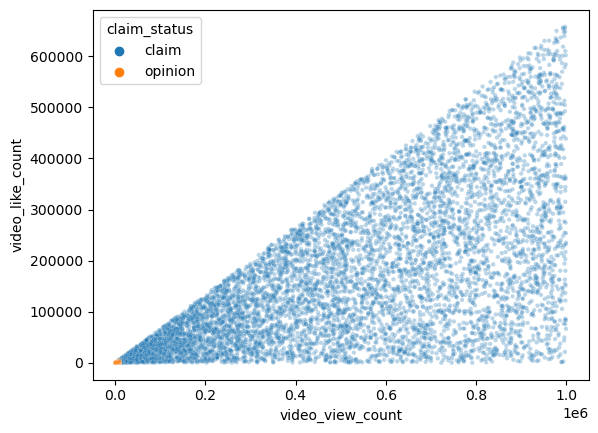

In [26]:
# Create a scatterplot of `video_like_count` versus `video_comment_count` according to 'claim_status'
sns.scatterplot(x=train["video_view_count"], y=train["video_like_count"],
                hue=train["claim_status"], s=10, alpha=.3)
plt.show()

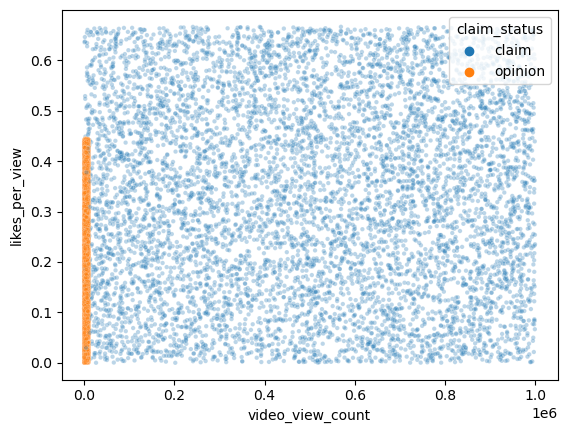

In [27]:
# Create a scatterplot of `video_like_count` versus `video_comment_count` according to 'claim_status'
sns.scatterplot(x=train["video_view_count"], y=train["likes_per_view"],
                hue=train["claim_status"], s=10, alpha=.3)
plt.show()

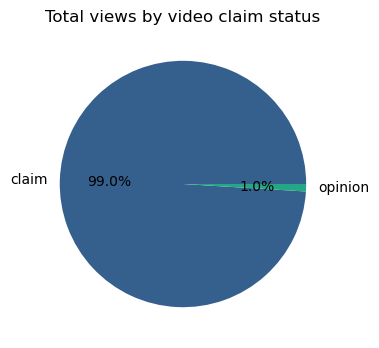

In [35]:
cmap = plt.get_cmap('viridis')
blue = cmap(0.3)   # Pick a blue from the colormap
green = cmap(0.6)  # Pick a green from the colormap
colors = [blue, green]

fig = plt.figure(figsize=(4,4))
plt.pie(train.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'], autopct='%1.1f%%', colors=colors)
plt.title('Total views by video claim status');

<ipython-input-267-709382ab5168>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='claim_status', palette='viridis')


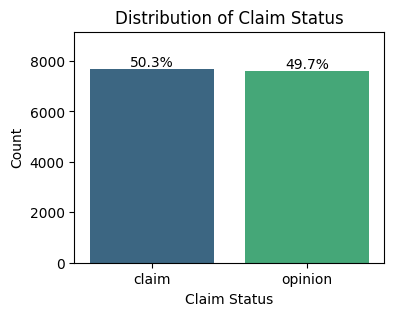

In [ ]:
# Claim_status

plt.figure(figsize=(4, 3))
sns.countplot(data=train, x='claim_status', palette='viridis')


for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height, f'{height / len(train):.1%}', ha='center', va='bottom')

plt.title('Distribution of Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Count')

plt.ylim(0, len(train) * 0.6)
plt.show()

<ipython-input-268-89175a2a49a9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='author_ban_status', palette='viridis')


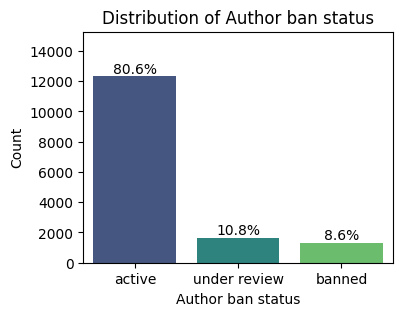

In [ ]:
# author_ban_status

# Create a bar plot
plt.figure(figsize=(4, 3))
sns.countplot(data=train, x='author_ban_status', palette='viridis')

# Add percentage labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height, f'{height / len(train):.1%}', ha='center', va='bottom')

plt.title('Distribution of Author ban status')
plt.xlabel('Author ban status')
plt.ylabel('Count')

# Set the y-axis limit
plt.ylim(0, len(train))
plt.show()

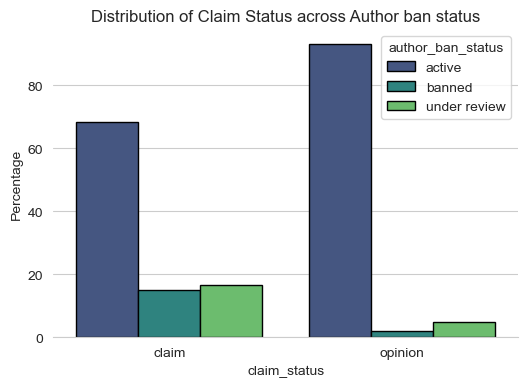

In [52]:
# Distribution of Claim Status across Author ban status

table = train.groupby(['claim_status','author_ban_status']).size().reset_index(name='Frequency')
table['Percentage'] = table.groupby('claim_status')['Frequency'].transform(lambda x: x / x.sum() * 100)
plt.figure(figsize=(6,4))
sns.barplot(data=table, x='claim_status', y='Percentage', hue='author_ban_status', edgecolor='black', palette='viridis').set(title='Distribution of Claim Status across Author ban status')

sns.set_style("whitegrid")
sns.despine(left=True)
plt.show()

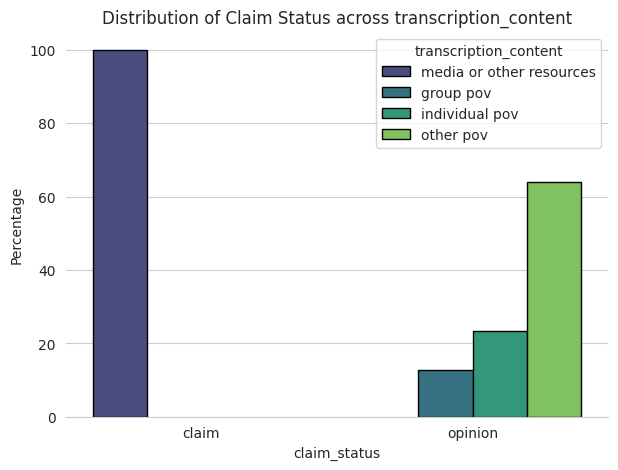

In [ ]:
# Distribution of Claim Status across transcription_content

table = train.groupby(['claim_status','transcription_content']).size().reset_index(name='Frequency')
table['Percentage'] = table.groupby('claim_status')['Frequency'].transform(lambda x: x / x.sum() * 100)
plt.figure(figsize=(7, 5))
sns.barplot(data=table, x='claim_status', y='Percentage', hue='transcription_content', edgecolor='black', palette='viridis').set(title='Distribution of Claim Status across transcription_content')

sns.set_style("whitegrid")
sns.despine(left=True)
plt.show()

<ipython-input-271-a506bb6e5fcd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='verified_status', palette='viridis')


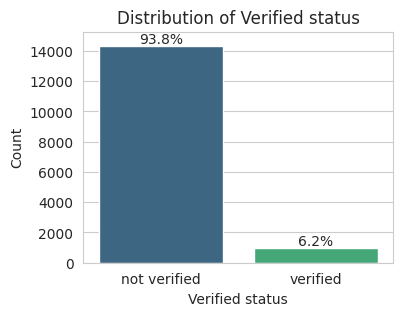

In [ ]:
# verified_status

plt.figure(figsize=(4, 3))
sns.countplot(data=train, x='verified_status', palette='viridis')

for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height, f'{height / len(train):.1%}', ha='center', va='bottom')

plt.title('Distribution of Verified status')
plt.xlabel('Verified status')
plt.ylabel('Count')

plt.ylim(0, len(train))
plt.show()

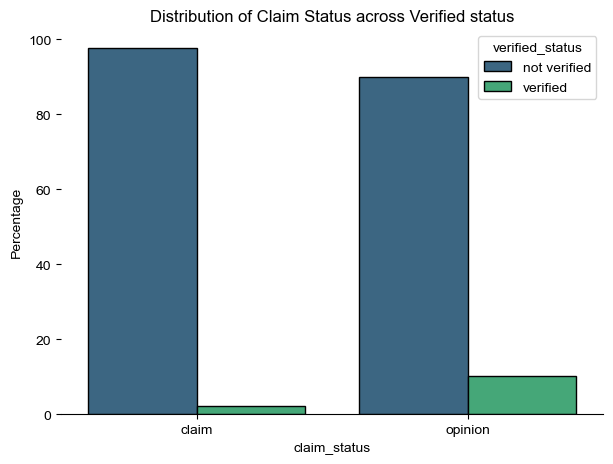

In [36]:
# Distribution of Verified Status across claim_status
table = train.groupby(['claim_status','verified_status']).size().reset_index(name='Frequency')
table['Percentage'] = table.groupby('claim_status')['Frequency'].transform(lambda x: x / x.sum() * 100)
plt.figure(figsize=(7, 5))
sns.barplot(data=table, x='claim_status', y='Percentage', hue='verified_status', edgecolor='black', palette='viridis').set(title='Distribution of Claim Status across Verified status')

sns.set_style("whitegrid")
sns.despine(left=True)
plt.show()

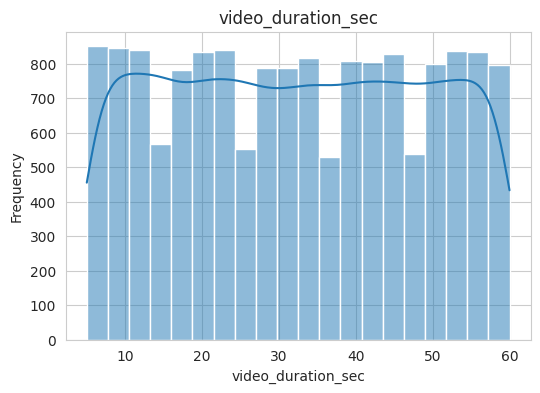

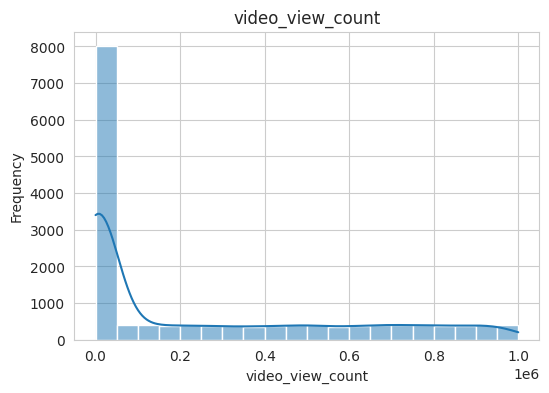

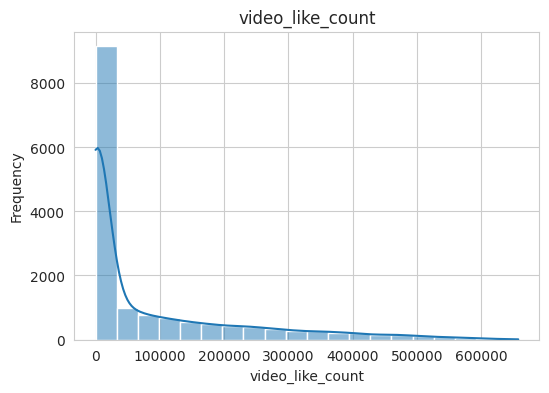

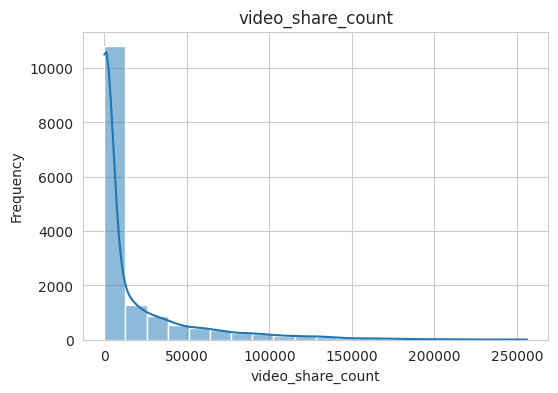

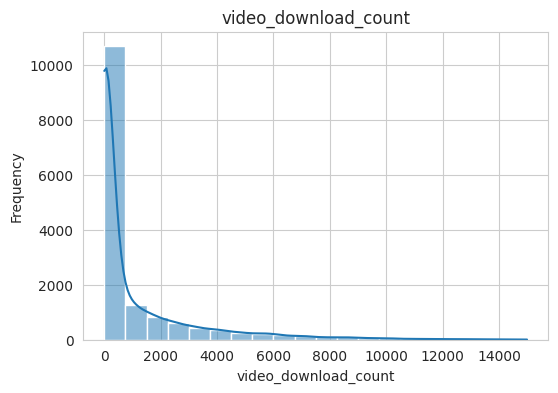

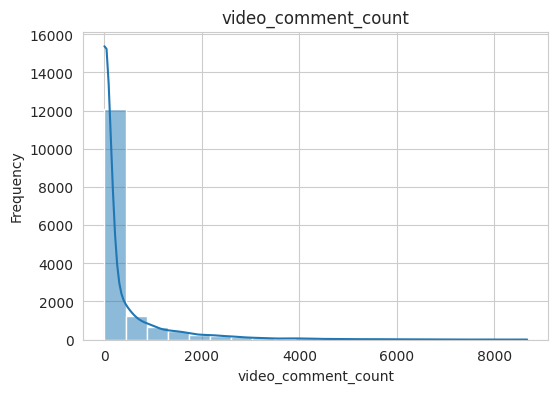

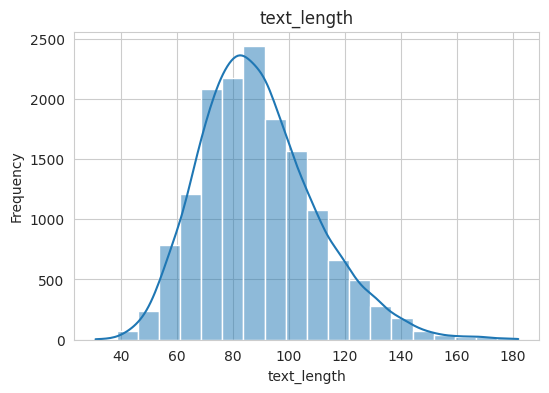

In [ ]:
# continous variables distribution

for i in ['video_duration_sec',	'video_view_count',	'video_like_count',	'video_share_count','video_download_count',	'video_comment_count','text_length']:
  plt.figure(figsize=(6, 4))
  sns.histplot(train[i], bins=20, kde=True)
  plt.title(i)
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.show()

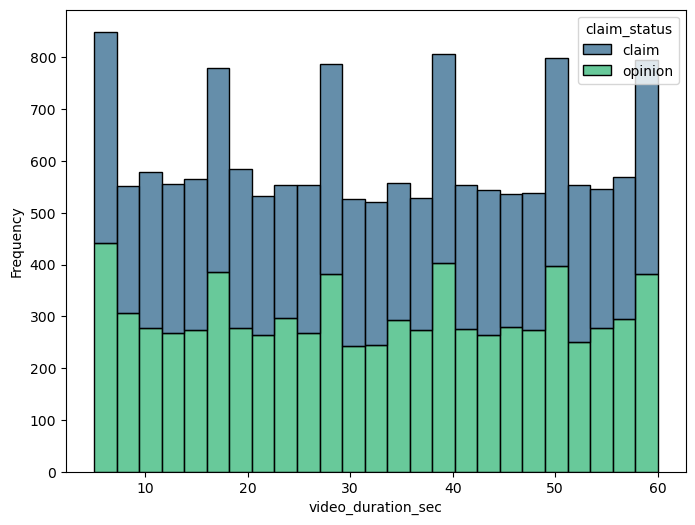

In [34]:
plt.figure(figsize=(8,6))
sns.histplot(data=train, x='video_duration_sec', hue='claim_status', multiple='stack', palette = 'viridis')
plt.xlabel('video_duration_sec')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [30]:
y_train.value_counts()

claim      7680
opinion    7587
Name: claim_status, dtype: int64

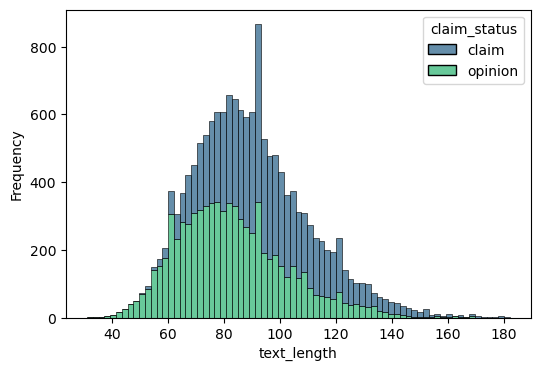

In [29]:
plt.figure(figsize=(6,4))
sns.histplot(data=train, x='text_length', hue='claim_status', multiple='stack', palette = 'viridis')
plt.xlabel('text_length')
plt.ylabel('Frequency')

# Display the plot
plt.show()

<Axes: xlabel='text_length', ylabel='Percent'>

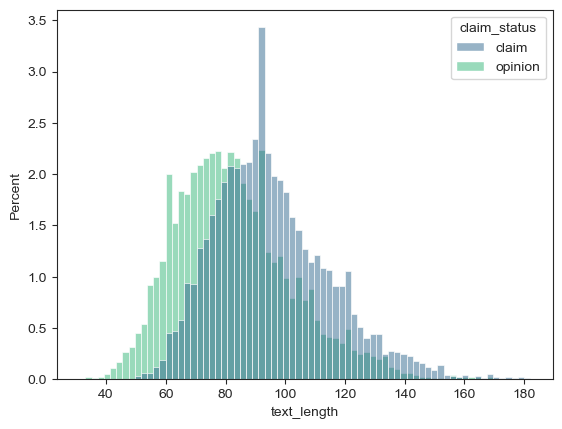

In [40]:
sns.histplot(data=train, x="text_length", hue="claim_status",stat="percent", palette = 'viridis')

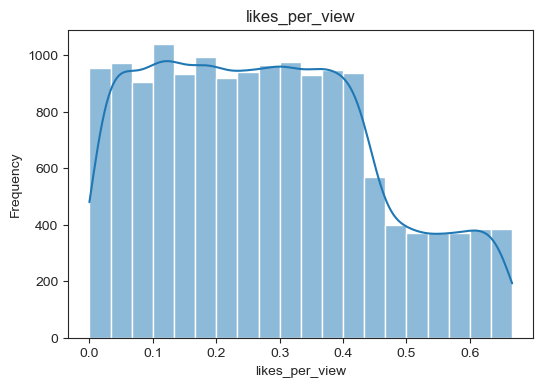

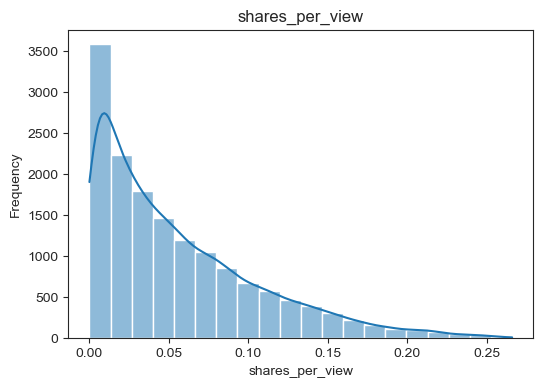

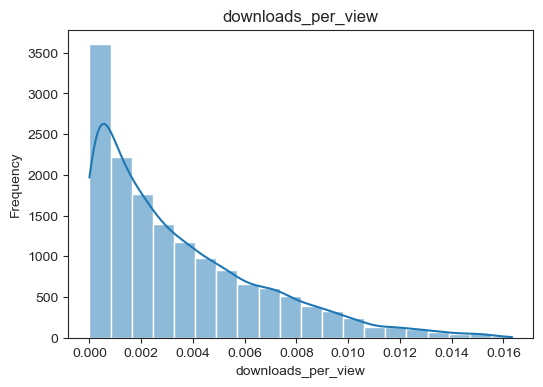

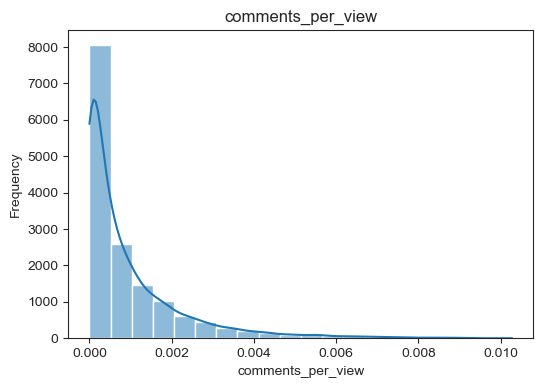

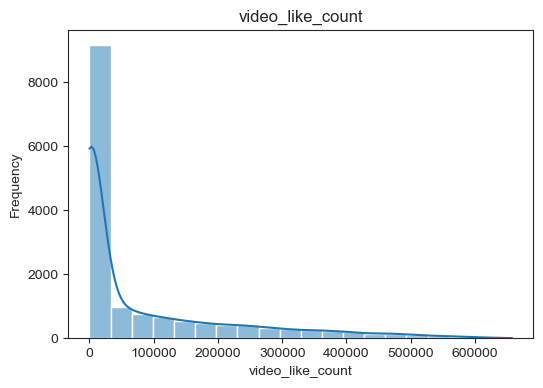

In [37]:
# continous variables distribution

for i in ['likes_per_view', 'shares_per_view', 'downloads_per_view', 'comments_per_view', 'video_like_count']:
  plt.figure(figsize=(6, 4))
  sns.set_style("ticks")
  sns.histplot(train[i], bins=20, kde=True)
  plt.title(i)
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.show()

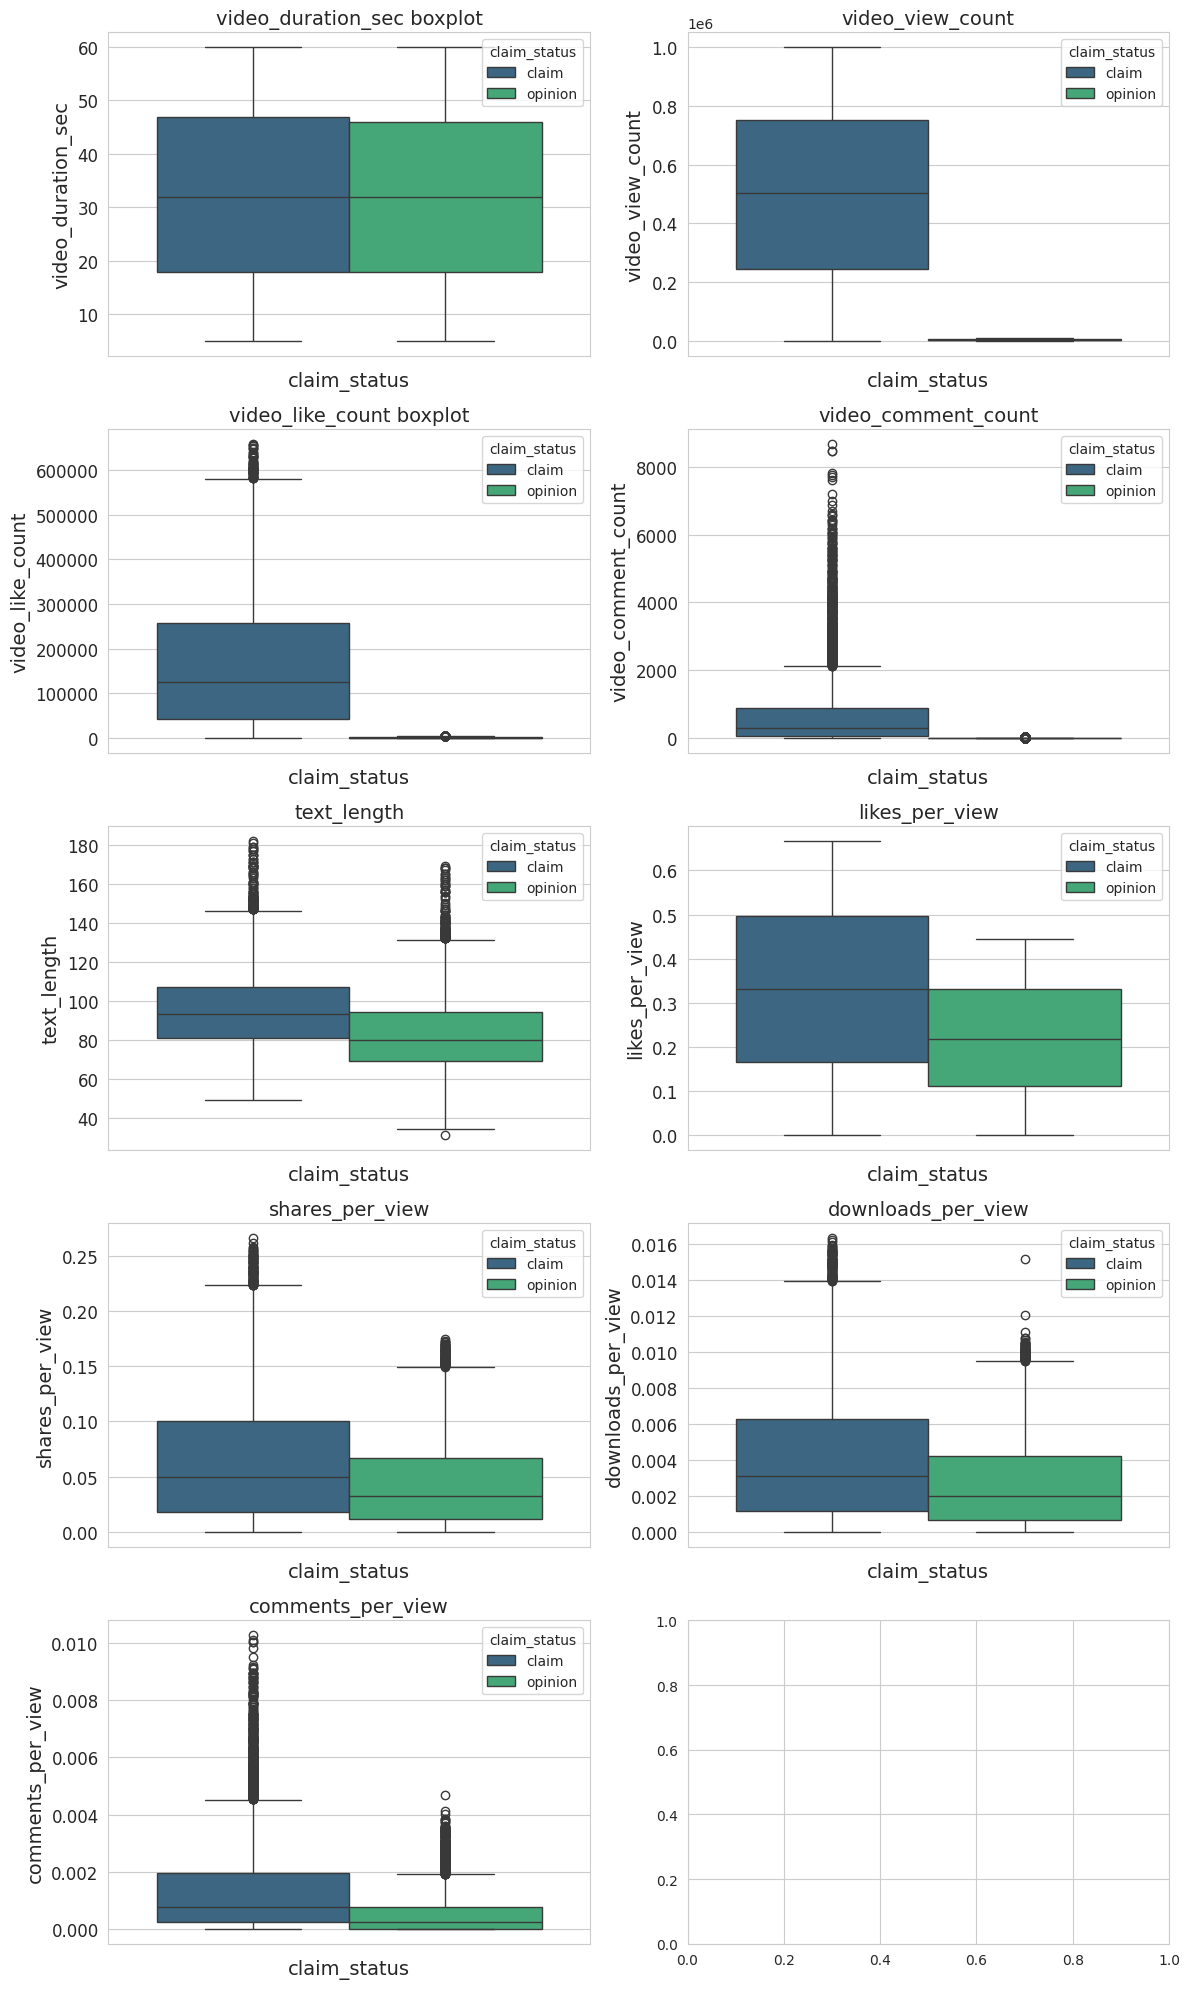

In [ ]:
# continous variable across the claim status

sns.set_style("whitegrid")
fig, axs = plt.subplots(5, 2, figsize=(12, 20))

# Plot for 'video_duration_sec'
sns.boxplot(data=train, y='video_duration_sec', hue='claim_status', palette='viridis', ax=axs[0,0])
axs[0,0].set_title('video_duration_sec boxplot', fontsize=14)
axs[0,0].set_xlabel('claim_status', fontsize=14)
axs[0,0].set_ylabel('video_duration_sec', fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'video_view_count'
sns.boxplot(data=train, y='video_view_count', hue='claim_status', palette='viridis', ax=axs[0,1])
axs[0,1].set_title('video_view_count', fontsize=14)
axs[0,1].set_xlabel('claim_status', fontsize=14)
axs[0,1].set_ylabel('video_view_count', fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'video_like_count'
sns.boxplot(data=train, y='video_like_count', hue='claim_status', palette='viridis', ax=axs[1,0])
axs[1,0].set_title('video_like_count boxplot', fontsize=14)
axs[1,0].set_xlabel('claim_status', fontsize=14)
axs[1,0].set_ylabel('video_like_count', fontsize=14)
axs[1,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'video_comment_count'
sns.boxplot(data=train, y='video_comment_count', hue='claim_status', palette='viridis', ax=axs[1,1])
axs[1,1].set_title('video_comment_count', fontsize=14)
axs[1,1].set_xlabel('claim_status', fontsize=14)
axs[1,1].set_ylabel('video_comment_count', fontsize=14)
axs[1,1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'text_length'
sns.boxplot(data=train, y='text_length', hue='claim_status', palette='viridis', ax=axs[2,0])
axs[2,0].set_title('text_length', fontsize=14)
axs[2,0].set_xlabel('claim_status', fontsize=14)
axs[2,0].set_ylabel('text_length', fontsize=14)
axs[2,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'likes_per_view'
sns.boxplot(data=train, y='likes_per_view', hue='claim_status', palette='viridis', ax=axs[2,1])
axs[2,1].set_title('likes_per_view', fontsize=14)
axs[2,1].set_xlabel('claim_status', fontsize=14)
axs[2,1].set_ylabel('likes_per_view', fontsize=14)
axs[2,1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'shares_per_view'
sns.boxplot(data=train, y='shares_per_view', hue='claim_status', palette='viridis', ax=axs[3,0])
axs[3,0].set_title('shares_per_view', fontsize=14)
axs[3,0].set_xlabel('claim_status', fontsize=14)
axs[3,0].set_ylabel('shares_per_view', fontsize=14)
axs[3,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'downloads_per_view'
sns.boxplot(data=train, y='downloads_per_view', hue='claim_status', palette='viridis', ax=axs[3,1])
axs[3,1].set_title('downloads_per_view', fontsize=14)
axs[3,1].set_xlabel('claim_status', fontsize=14)
axs[3,1].set_ylabel('downloads_per_view', fontsize=14)
axs[3,1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'comments_per_view'
sns.boxplot(data=train, y='comments_per_view', hue='claim_status', palette='viridis', ax=axs[4,0])
axs[4,0].set_title('comments_per_view', fontsize=14)
axs[4,0].set_xlabel('claim_status', fontsize=14)
axs[4,0].set_ylabel('comments_per_view', fontsize=14)
axs[4,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size


plt.tight_layout()
plt.show()

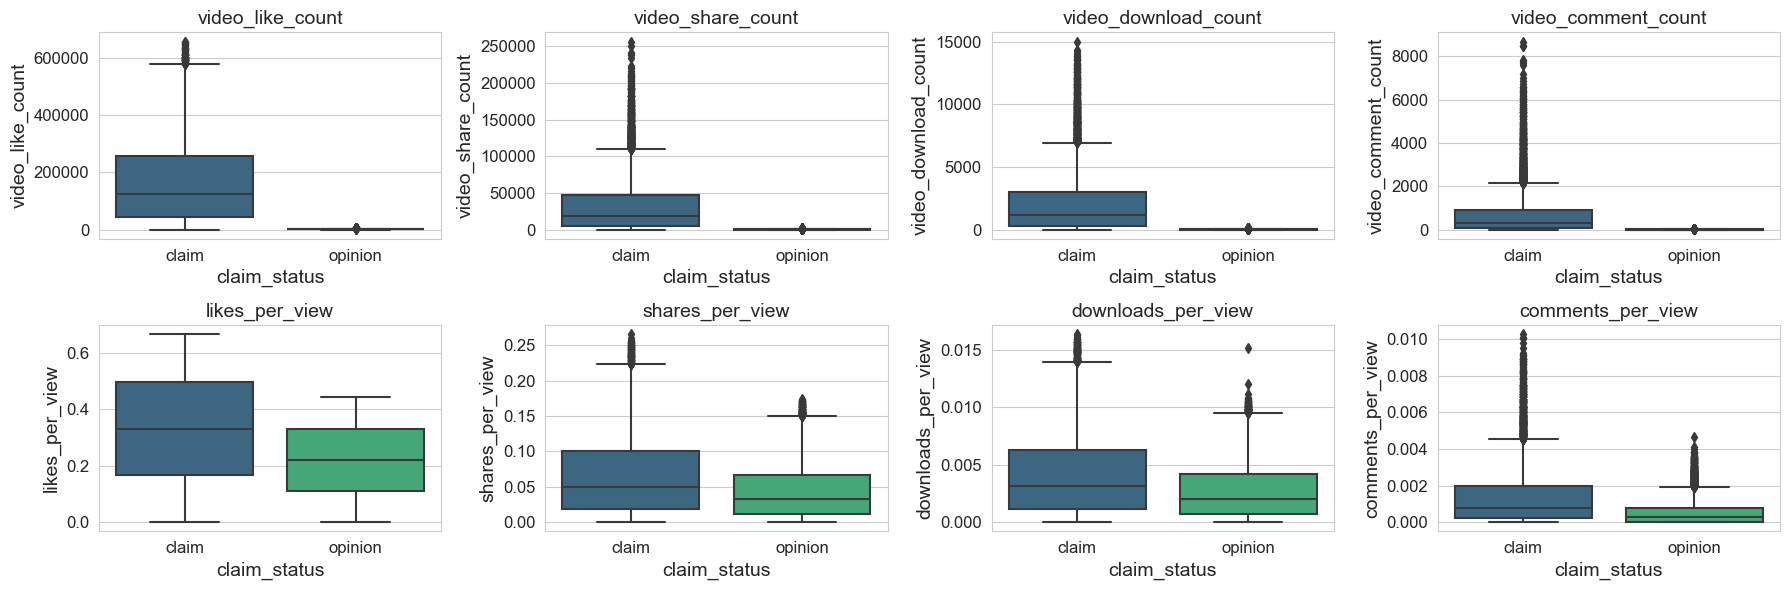

In [35]:
# continous variable across the claim status

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 4, figsize=(18,6))

# Plot for 'video_like_count'
sns.boxplot(data=train, y='video_like_count', x='claim_status', palette='viridis', ax=axs[0,0])
axs[0,0].set_title('video_like_count', fontsize=14)
axs[0,0].set_xlabel('claim_status', fontsize=14)
axs[0,0].set_ylabel('video_like_count', fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'video_share_count'
sns.boxplot(data=train, y='video_share_count', x='claim_status', palette='viridis', ax=axs[0,1])
axs[0,1].set_title('video_share_count', fontsize=14)
axs[0,1].set_xlabel('claim_status', fontsize=14)
axs[0,1].set_ylabel('video_share_count', fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'video_download_count'
sns.boxplot(data=train, y='video_download_count', x='claim_status', palette='viridis', ax=axs[0,2])
axs[0,2].set_title('video_download_count', fontsize=14)
axs[0,2].set_xlabel('claim_status', fontsize=14)
axs[0,2].set_ylabel('video_download_count', fontsize=14)
axs[0,2].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'video_comment_count'
sns.boxplot(data=train, y='video_comment_count', x='claim_status', palette='viridis', ax=axs[0,3])
axs[0,3].set_title('video_comment_count', fontsize=14)
axs[0,3].set_xlabel('claim_status', fontsize=14)
axs[0,3].set_ylabel('video_comment_count', fontsize=14)
axs[0,3].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'likes_per_view'
sns.boxplot(data=train, y='likes_per_view', x='claim_status', palette='viridis', ax=axs[1,0])
axs[1,0].set_title('likes_per_view', fontsize=14)
axs[1,0].set_xlabel('claim_status', fontsize=14)
axs[1,0].set_ylabel('likes_per_view', fontsize=14)
axs[1,0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'shares_per_view'
sns.boxplot(data=train, y='shares_per_view', x='claim_status', palette='viridis', ax=axs[1,1])
axs[1,1].set_title('shares_per_view', fontsize=14)
axs[1,1].set_xlabel('claim_status', fontsize=14)
axs[1,1].set_ylabel('shares_per_view', fontsize=14)
axs[1,1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'downloads_per_view'
sns.boxplot(data=train, y='downloads_per_view', x='claim_status', palette='viridis', ax=axs[1,2])
axs[1,2].set_title('downloads_per_view', fontsize=14)
axs[1,2].set_xlabel('claim_status', fontsize=14)
axs[1,2].set_ylabel('downloads_per_view', fontsize=14)
axs[1,2].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size

# Plot for 'comments_per_view'
sns.boxplot(data=train, y='comments_per_view', x='claim_status', palette='viridis', ax=axs[1,3])
axs[1,3].set_title('comments_per_view', fontsize=14)
axs[1,3].set_xlabel('claim_status', fontsize=14)
axs[1,3].set_ylabel('comments_per_view', fontsize=14)
axs[1,3].tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size


plt.tight_layout()
plt.show()

In [ ]:
pip install dython

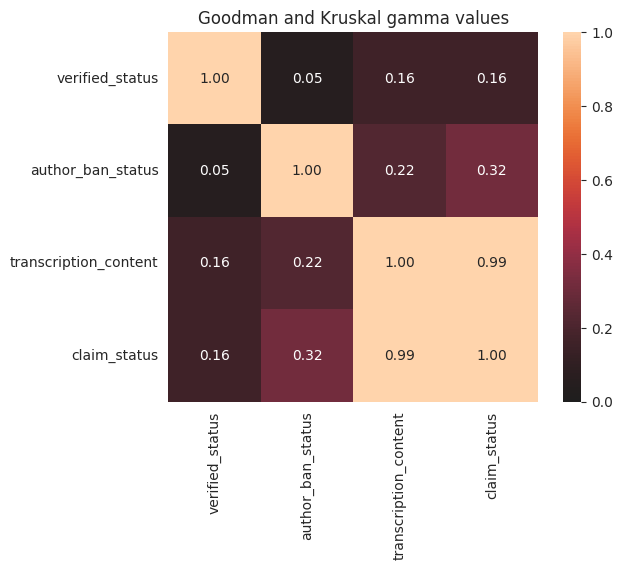

In [ ]:
# Goodman and Kruskal's gamma values

from dython.nominal import associations
g_f = train.select_dtypes(exclude=['float64','int64'])
association_results = associations(g_f, nominal_columns='all', plot=True, title='Goodman and Kruskal gamma values')

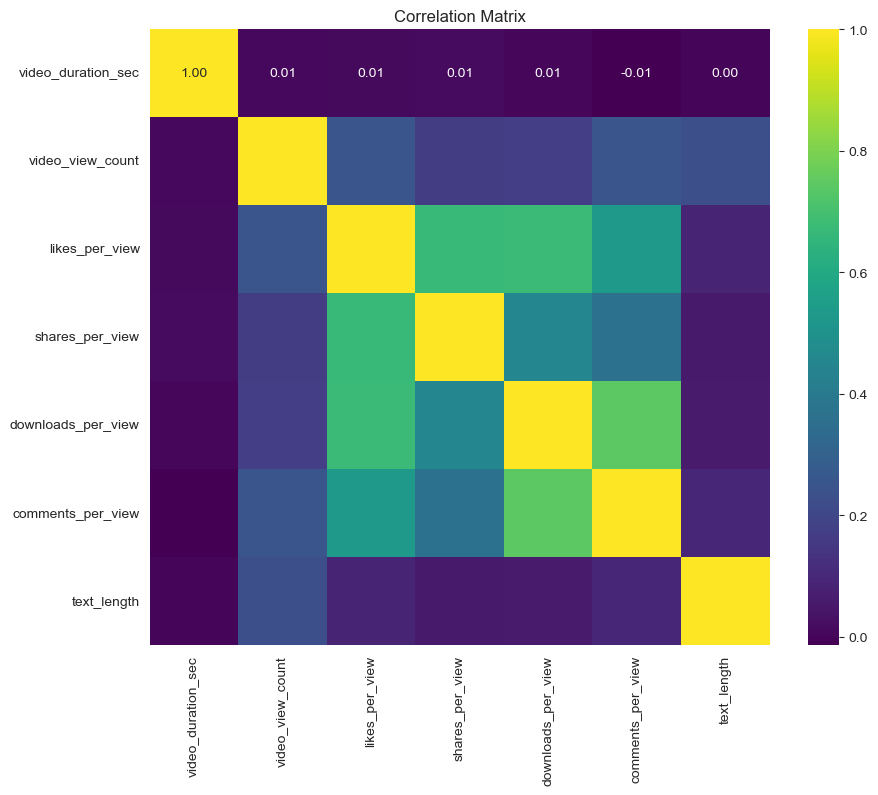

In [70]:
# correlation matrix

numeric = train.select_dtypes(include=['int64','float64'])
numeric.drop(columns = ['video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count'], inplace = True)
correlation_matrix = numeric.corr()

sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Factor Analysis

In [43]:
pip install prince

   ---------------------------------------- 0.0/415.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/415.6 kB ? eta -:--:--
    --------------------------------------- 10.2/415.6 kB ? eta -:--:--
    --------------------------------------- 10.2/415.6 kB ? eta -:--:--
   -- ------------------------------------ 30.7/415.6 kB 186.2 kB/s eta 0:00:03
   -- ------------------------------------ 30.7/415.6 kB 186.2 kB/s eta 0:00:03
   --- ----------------------------------- 41.0/415.6 kB 140.3 kB/s eta 0:00:03
   ----- --------------------------------- 61.4/415.6 kB 192.5 kB/s eta 0:00:02
   ------- ------------------------------- 81.9/415.6 kB 229.0 kB/s eta 0:00:02
   ------- ------------------------------- 81.9/415.6 kB 229.0 kB/s eta 0:00:02
   ------- ------------------------------- 81.9/415.6 kB 229.0 kB/s eta 0:00:02
   ---------- --------------------------- 112.6/415.6 kB 233.8 kB/s eta 0:00:02
   ---------- --------------------------- 112.6/415.6 kB 233.8 kB/s eta 0:

In [54]:
# drop columns from X_train
#'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count','transcription_content', 'scores', 'anomaly_score'

famd_X_train = X_train.drop(columns = ['video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count'])

import prince
famd = prince.FAMD(
    n_components=famd_X_train.shape[1],
    n_iter=10,
    copy=True,
    check_input=True,
    random_state=0,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(famd_X_train)

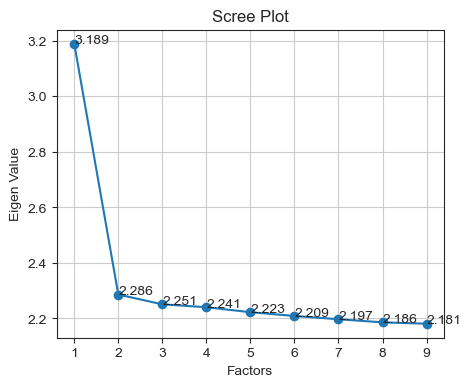

In [61]:
ev = famd.eigenvalues_

plt.figure(figsize=(5,4))
plt.scatter(range(1,famd_X_train.shape[1]+1),ev)
plt.plot(range(1,famd_X_train.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

for i, txt in enumerate(ev.round(3)):
    plt.annotate(txt, (i+1, ev[i]))

In [57]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.189,0.78%,0.78%
1,2.286,0.56%,1.35%
2,2.251,0.55%,1.90%
3,2.241,0.55%,2.45%
4,2.223,0.55%,2.99%
5,2.209,0.54%,3.54%
6,2.197,0.54%,4.08%
7,2.186,0.54%,4.61%
8,2.181,0.54%,5.15%


In [52]:
famd.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7,8
variable,,,,,,,,,
video_view_count,8%,1%,0%,0%,0%,0%,0%,0%,0%
likes_per_view,18%,1%,0%,0%,0%,0%,0%,0%,0%
shares_per_view,12%,1%,0%,0%,0%,0%,0%,0%,0%
downloads_per_view,16%,2%,0%,0%,0%,1%,0%,0%,0%
comments_per_view,15%,1%,0%,0%,0%,0%,0%,0%,0%
author_ban_status,6%,4%,2%,0%,4%,1%,1%,0%,0%
text_length,7%,23%,25%,26%,26%,28%,27%,27%,28%
verified_status,2%,2%,0%,0%,0%,0%,0%,0%,0%
video_duration_sec,1%,18%,23%,24%,20%,20%,22%,22%,22%


In [64]:
famd_X_train.to_csv('famd_train.csv')

K Means with Gower distance

In [26]:
pip install gower

Note: you may need to restart the kernel to use updated packages.


In [30]:
X_train_counts = X_train.drop(columns = ['likes_per_view','shares_per_view','downloads_per_view','comments_per_view'])
X_train_counts

,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
5142,46,not verified,active,532092.0,269442.0,77939.0,5624.0,28.0,88
11131,49,not verified,active,4081.0,1306.0,471.0,31.0,8.0,83
8374,54,not verified,active,495598.0,17428.0,5819.0,301.0,10.0,100
8471,54,not verified,active,960619.0,7256.0,2331.0,116.0,56.0,135
13714,48,not verified,active,7818.0,1932.0,34.0,2.0,0.0,103
...,...,...,...,...,...,...,...,...,...
11284,19,not verified,active,5199.0,963.0,254.0,6.0,1.0,80
11964,43,not verified,active,8410.0,1814.0,10.0,5.0,2.0,79
5390,28,not verified,active,658519.0,277852.0,70482.0,6227.0,2405.0,110
860,8,not verified,active,47460.0,7080.0,2021.0,38.0,9.0,94


In [31]:
import gower

distance_matrix = gower.gower_matrix(X_train_counts)
distance_matrix

array([[0.        , 0.18902734, 0.14257674, ..., 0.10617703, 0.25393626,
        0.21357968],
       [0.18902734, 0.        , 0.08431266, ..., 0.28873456, 0.09745646,
        0.04403191],
       [0.14257674, 0.08431266, 0.        , ..., 0.22462392, 0.15251277,
        0.10332618],
       ...,
       [0.10617703, 0.28873456, 0.22462392, ..., 0.        , 0.27208617,
        0.26070815],
       [0.25393626, 0.09745646, 0.15251277, ..., 0.27208617, 0.        ,
        0.09297676],
       [0.21357968, 0.04403191, 0.10332618, ..., 0.26070815, 0.09297676,
        0.        ]], dtype=float32)

In [ ]:
# K Means with gower distance
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=2,random_state=42)
k_means.fit(distance_matrix)

train['KMeans_gower_labels'] = k_means.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(distance_matrix, k_means.labels_)

0.51287144

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:

 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(distance_matrix)
 cluster_labels = kmeans.labels_

 # silhouette score
 silhouette_avg.append(silhouette_score(distance_matrix, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

DBSCAN with gower distance

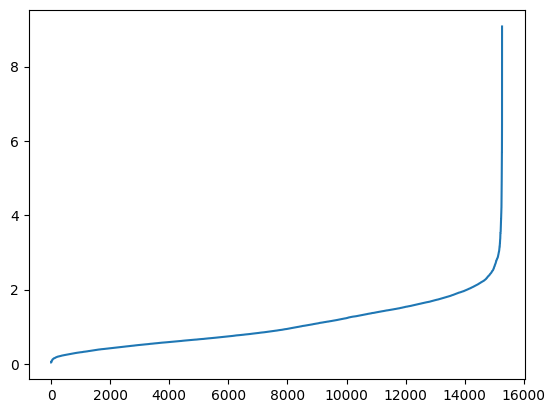

In [ ]:
 #KNN for DBSCAN

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=26)
dataset = distance_matrix
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps= 2, min_samples = 26)
dbscan.fit(distance_matrix)

train['DBSCAN_gower_labels'] = dbscan.labels_

NameError: name 'distance_matrix' is not defined

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(distance_matrix, dbscan.labels_)

In [ ]:
# unique values and their counts in dbscan variable
train['DBSCAN_gower_labels'].value_counts()

Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2)
model.fit(distance_matrix)

train['HR_labels'] = model.labels_
silhouette_score(distance_matrix, model.labels_)

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


0.5152451

Outlier Detection

In [70]:
from sklearn.ensemble import IsolationForest

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15267 entries, 5142 to 15795
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   video_duration_sec    15267 non-null  int64  
 1   verified_status       15267 non-null  object 
 2   author_ban_status     15267 non-null  object 
 3   video_view_count      15267 non-null  float64
 4   video_like_count      15267 non-null  float64
 5   video_share_count     15267 non-null  float64
 6   video_download_count  15267 non-null  float64
 7   video_comment_count   15267 non-null  float64
 8   likes_per_view        15267 non-null  float64
 9   shares_per_view       15267 non-null  float64
 10  downloads_per_view    15267 non-null  float64
 11  comments_per_view     15267 non-null  float64
 12  text_length           15267 non-null  int64  
dtypes: float64(9), int64(2), object(2)
memory usage: 2.1+ MB


In [79]:
X_train_IF = X_train.drop(columns = ['video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count'])
X_test_IF = X_test.drop(columns = ['video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count'])

In [86]:
X_test_IF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3817 entries, 18920 to 8794
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_duration_sec  3817 non-null   int64  
 1   verified_status     3817 non-null   object 
 2   author_ban_status   3817 non-null   object 
 3   video_view_count    3817 non-null   float64
 4   likes_per_view      3817 non-null   float64
 5   shares_per_view     3817 non-null   float64
 6   downloads_per_view  3817 non-null   float64
 7   comments_per_view   3817 non-null   float64
 8   text_length         3817 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 427.2+ KB


In [115]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create transformers for numerical, ordinal, and categorical columns
numeric_transformer = StandardScaler()
encoder1 = OrdinalEncoder(categories=[['not verified', 'verified']])
encoder2 = OrdinalEncoder(categories=[['active', 'under review', 'banned']])
categorical_transformer = OneHotEncoder()

# Create a column transformer to apply transformations to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_train_IF.select_dtypes(include=['float64','int64']).columns),
        ("ord1", encoder1, ['verified_status']),
        ("ord2", encoder2, ['author_ban_status'])
    ])

# Create an Isolation Forest model
IF_model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.01),max_features=6, random_state=42)  # Set an initial value, will be optimized later

# Create a pipeline with preprocessing and the Isolation Forest model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', IF_model)
])

pipeline.fit(X_train_IF, y_train)

y_pred_train_IF = pipeline.predict(X_train_IF)
y_pred_test_IF = pipeline.predict(X_test_IF)

In [116]:
np.sum(y_pred_train_IF==-1)

153

In [117]:
np.sum(y_pred_test_IF==-1)

44

In [24]:
X_enc = df_cleaned_2.drop('claim_status', axis=1)
Y_enc = df_cleaned_2['claim_status']
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, Y_enc, test_size=0.2, random_state=42)
train_enc = X_train_enc.join(y_train_enc)
test_enc = X_test_enc.join(y_test_enc)

In [ ]:
def predict_response(row):
    if row['Kproto_Cluster'] == 0:
        return 'claim' 
    elif row['Kproto_Cluster'] == 1:
        # Convert the row to a DataFrame with a single row to match the expected input format
        X_test_cluster1 = pd.DataFrame([row.drop('Kproto_Cluster')])
        return pipeline.predict(X_test_cluster1)[0]

# Apply the function to the DataFrame
X_train['Predicted_Response'] = X_train.apply(predict_response, axis=1)
rf_train_ypred = X_train['Predicted_Response']
X_train = X_train.drop(columns=['Predicted_Response'])